In [1]:
!nvidia-smi

Wed Jul 21 11:54:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q -U watermark

In [3]:
!pip install -qq transformers


In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.9.0+cu102
transformers: 4.8.2



In [5]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
#!unzip /content/drive/MyDrive/datasets.zip

Archive:  /content/drive/MyDrive/datasets.zip
replace datasets/classifiedExtremismAnsar.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
df_ext_ans = pd.read_csv('/content/datasets/classifiedExtremismAnsar.txt', sep="\t", header=None, low_memory=False)

In [8]:
df_ext_ans.columns = ["messageID",	"threadID",	"threadName",	"memberID",	"memberName",	"message" ,	"p_Date",	"threadFirstMessageID",	"scoreP",	"scoreN",	"polarity",	"termsP",	"termsN"]

In [9]:
df = df_ext_ans

In [10]:
del df_ext_ans

In [11]:
df = df.drop(["messageID",	"threadID",	"threadName",	"memberID",	"memberName","p_Date",	"threadFirstMessageID",	"scoreP",	"scoreN",	"termsP",	"termsN"], axis=1)

In [12]:
df['message'] = df['message'].astype(str)

In [13]:
df.polarity.value_counts()

Inconclusive            65301
Positive Extreme        21334
Negative Extreme          796
Positive Non-Extreme      520
Negative Non-Extreme      491
Name: polarity, dtype: int64

In [14]:
df['label'] = pd.factorize(df['polarity'])[0]

In [15]:

def get_split(text):
    l_total = []
    l_parcial = []
    if len(text.split())//450 >0:
      n = len(text.split())//450
    else: 
      n = 1
    for w in range(n):
      if w == 0:
        l_parcial = text.split()[:500]
        l_total.append(" ".join(l_parcial))
      else:
        l_parcial = text.split()[w*450:w*450 + 500]
        l_total.append(" ".join(l_parcial))
    return l_total

In [16]:
df['message_split'] = df['message'].apply(get_split)

In [17]:
df['message_split']

0        [In the Name of Allah the Most Merciful الإخوة...
1        [http://www.timesonline.co.uk/tol/new...cle613...
2        [http://www.honoluluadvertiser.com/ar...904220...
3        [Iraq Office of the Assistant Secretary of Def...
4        [As'Salaamu alaikum. Because the war is over a...
                               ...                        
88437    [Quote: Originally Posted by insurgent may all...
88438    [Big tough Marine, huh? Quote: SYDNEY – An Ame...
88439                                         [hahahahaha]
88440    [Most of these "soldiers" foolishly and arroga...
88441    [Lieberman: U.S. to accept any Israeli policy ...
Name: message_split, Length: 88442, dtype: object

In [18]:
def data_augumentation(df, df_name):
    """
    Create a new dataframe from the original one because now one text may contain multiple subtexts of length 200. 
    Text correspond to subtexts from original text, while index correspond to its index of original set.
    """
    text_l = []
    label_l = []
    index_l = []
    for idx,row in df.iterrows():
      for l in row['message_split']:
        text_l.append(l)
        label_l.append(row['label'])
        index_l.append(idx)
    new_df = pd.DataFrame({'message':text_l, 'label':label_l, 'index':index_l})
    print("The " + df_name +" set now has " + str(len(new_df)) + ' subtexts extracted from ' + str(len(df)) + ' messsage.')
    return new_df



In [19]:
df = data_augumentation(df, df_name = 'all')

The all set now has 98252 subtexts extracted from 88442 messsage.


In [20]:

df.drop("index",axis=1)

,message,label
0,In the Name of Allah the Most Merciful الإخوة ...,0
1,http://www.timesonline.co.uk/tol/new...cle6139...,0
2,http://www.honoluluadvertiser.com/ar...9042203...,0
3,Iraq Office of the Assistant Secretary of Defe...,0
4,As'Salaamu alaikum. Because the war is over an...,1
...,...,...
98247,Quote: Originally Posted by insurgent may alla...,2
98248,"Big tough Marine, huh? Quote: SYDNEY – An Amer...",0
98249,hahahahaha,0
98250,"Most of these ""soldiers"" foolishly and arrogan...",0


In [21]:
#train_df = data_augumentation(df_train, df_name = 'training')
#val_df = data_augumentation(df_val, df_name  = 'validation')
#test_df = data_augumentation(df_test, df_name = 'testing')

In [22]:
#df['message_len'] = df['message'].astype(str).apply(len)
#calculating the length of headlines and descriptions
df['message_len'] = df['message'].apply(lambda x: len(str(x).split()))

In [23]:
df["message_len"].describe().apply(lambda x: format(x, 'f'))

count    98252.000000
mean       178.612201
std        185.413148
min          1.000000
25%         22.000000
50%         94.000000
75%        305.000000
max        500.000000
Name: message_len, dtype: object

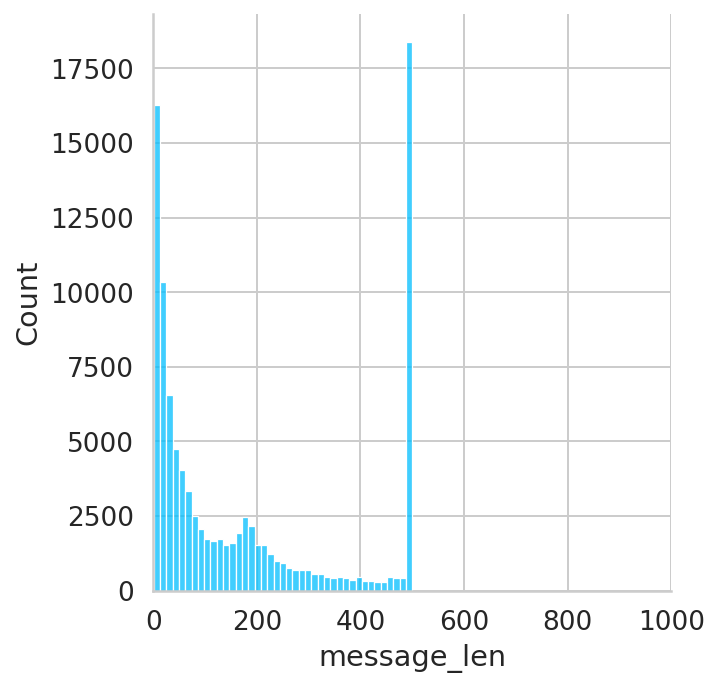

In [24]:
sns.displot( df , x= "message_len" );
plt.xlim([0, 1000]);


In [25]:
df.label.value_counts()


0    68200
2    27682
3      949
1      824
4      597
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


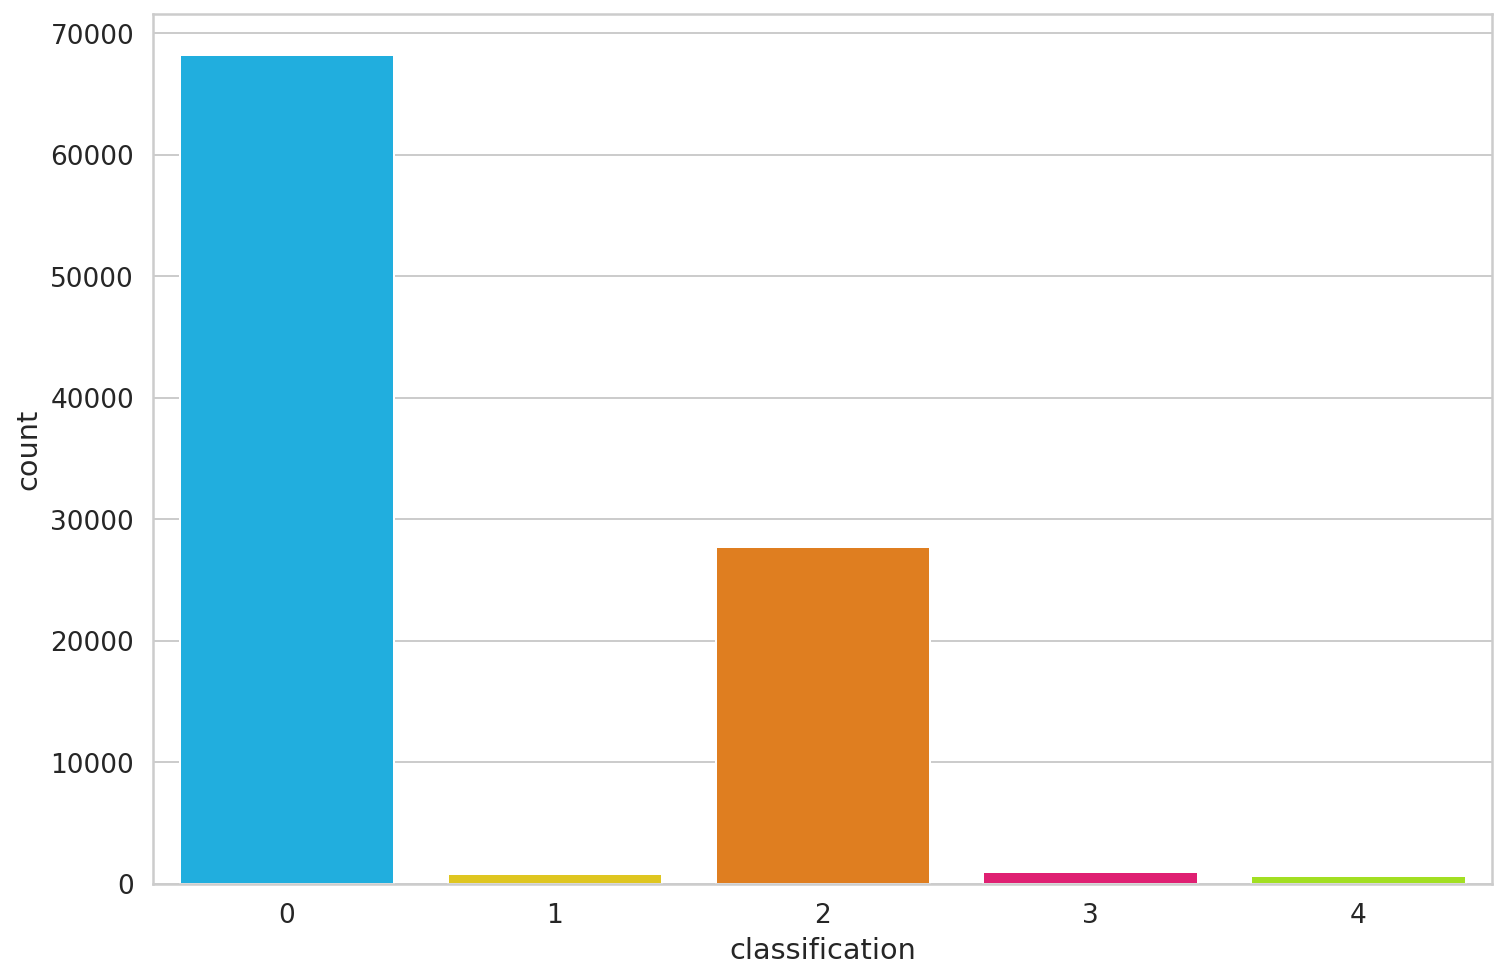

In [26]:
sns.countplot(df.label)
plt.xlabel('classification');

In [27]:
class_names = ['Inconclusive', 'Positive Extreme', 'Negative Extreme','Positive Non-Extreme','Negative Non-Extreme']

In [28]:
df = df.drop(columns= ["index","message_len"],axis=1)

In [29]:

# Class count
count_class_0, count_class_1,count_class_2,count_class_3,count_class_4 = df.label.value_counts()

# Divide by class
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]
df_class_2 = df[df['label'] == 2]
df_class_3 = df[df['label'] == 3]
df_class_4 = df[df['label'] == 4]

Random under-sampling:
3    597
1    597
4    597
2    597
0    597
Name: label, dtype: int64


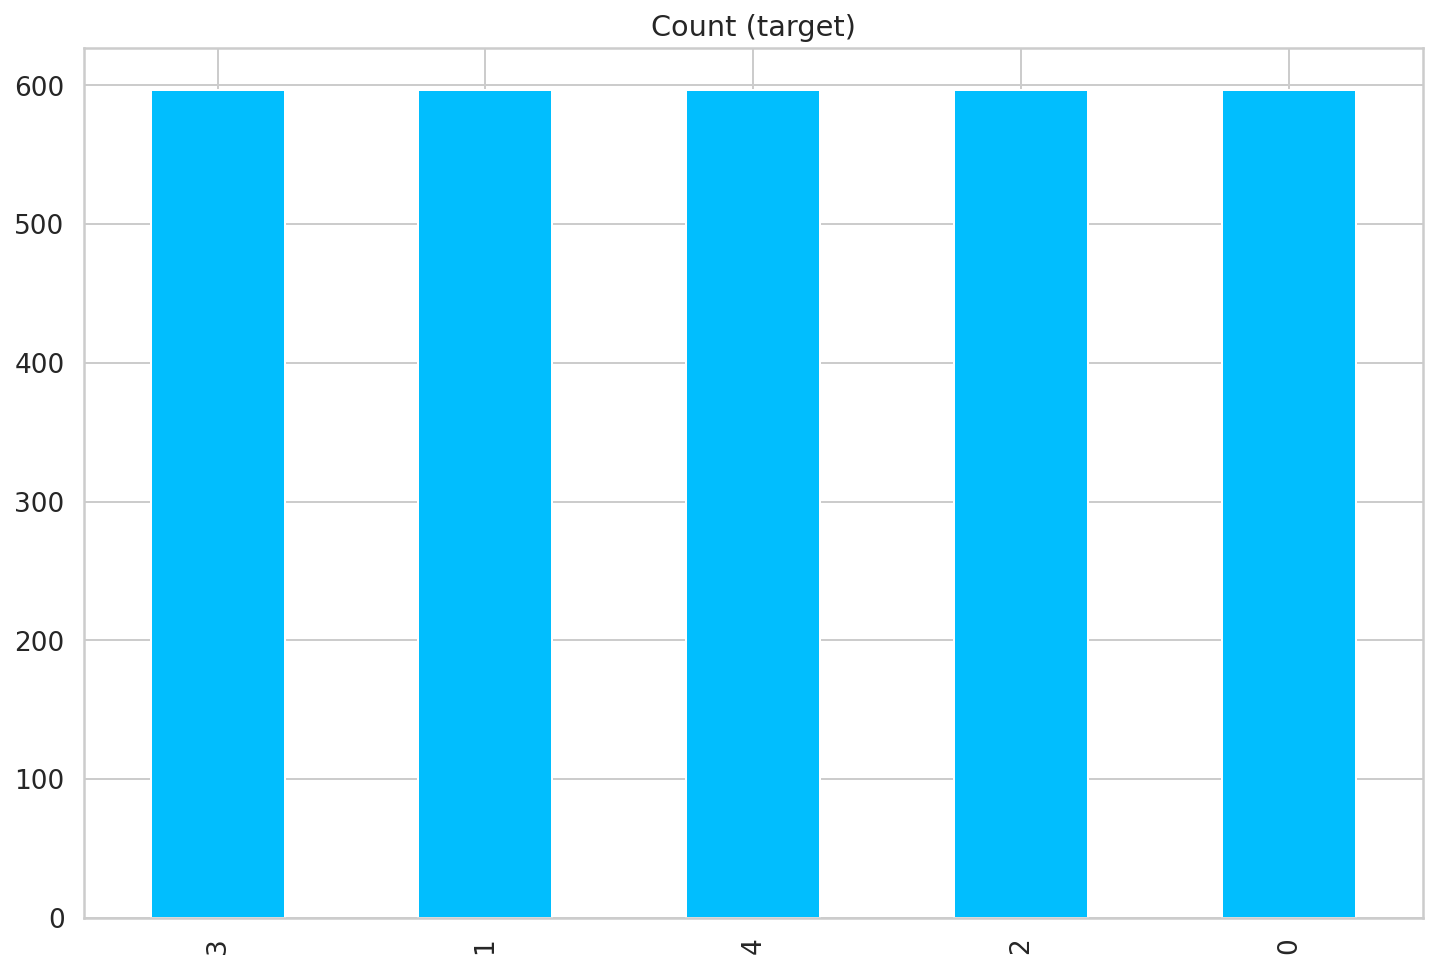

In [30]:
df_class_0_under = df_class_0.sample(count_class_4)
df_class_1_under = df_class_1.sample(count_class_4)
df_class_2_under = df_class_2.sample(count_class_4)
df_class_3_under = df_class_3.sample(count_class_4)
df_test_under = pd.concat([df_class_0_under, df_class_1_under,df_class_2_under,df_class_3_under , df_class_4], axis=0)

print('Random under-sampling:')
print(df_test_under.label.value_counts())

df_test_under.label.value_counts().plot(kind='bar', title='Count (target)');

In [31]:
df_test_under.head()

,message,label
75015,Allahuabar!such a nice photo of this great muj...,0
55793,partial subtitled...just watch You can find th...,0
42740,Removed from Imam TV website for unknown reaso...,0
33729,بسم الله الرحمن الرحيم مقتل 5 شرطيين في هجوم ع...,0
42422,بسم الله الرحمن الرحيم خسائر قتل وإصابة بالجنو...,0


In [32]:
df_test_under = df_test_under.sample(frac=1).reset_index(drop=True)

In [33]:
df_test_under.head(10)

,message,label
0,SEATTLE – A suspect in the slaying of four pol...,4
1,US: Taliban has grown fourfold UPDATED ON: Fri...,3
2,The Old Cabinet Abu Abdul Rahman al-Falahi - P...,2
3,Islamic Emirate of Afghanistan military operat...,0
4,In the name of Allah most Gracious most mercif...,3
5,"DAMASCUS, Syria – Turkey's prime minister said...",3
6,"the child-rape investigation, the sheriff's of...",4
7,Quote: Originally Posted by Abu Hamza Why are ...,2
8,"percent of who're 35-54, and hitting 61 percen...",2
9,Quote: Originally Posted by hammadal dear brot...,1


In [34]:
df_train, df_test = train_test_split(
  df_test_under,
  test_size=0.2,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [35]:
df_train.shape, df_val.shape, df_test.shape

((2388, 2), (298, 2), (299, 2))

In [36]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [37]:
#PRE_TRAINED_MODEL_NAME = "bert-base-multilingual-uncased"
PRE_TRAINED_MODEL_NAME = "bert-base-cased"

In [38]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [39]:
MAX_LEN = 512

In [40]:
class ExtremsSentiDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):

    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
      
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [41]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ExtremsSentiDataset(
    reviews=df.message.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2,
    shuffle=True
  )

In [42]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)



In [43]:
data = next(iter(train_data_loader))
data.keys()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [44]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [46]:

model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 512])
torch.Size([8, 512])


In [48]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.4 GB
Cached:    0.5 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [49]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 512])
torch.Size([8, 512])


In [50]:

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.4 GB
Cached:    0.5 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [51]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2795, 0.1777, 0.0924, 0.1378, 0.3126],
        [0.1917, 0.1447, 0.1487, 0.2351, 0.2799],
        [0.2775, 0.2845, 0.1155, 0.1735, 0.1490],
        [0.2430, 0.1491, 0.1058, 0.2054, 0.2968],
        [0.2001, 0.1839, 0.1577, 0.1611, 0.2972],
        [0.1847, 0.1768, 0.1383, 0.2524, 0.2479],
        [0.2563, 0.2465, 0.1164, 0.1479, 0.2330],
        [0.1772, 0.2911, 0.1020, 0.2080, 0.2218]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [52]:
EPOCHS = 6
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [53]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [54]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [55]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [56]:
!nvidia-smi

Wed Jul 21 11:55:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    37W /  70W |   6164MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [57]:


import torch

# Check GPU memory using nvidia-smi
#del train_data_loader
#del val_data_loader
#del test_data_loader
torch.cuda.empty_cache()
# Check GPU memory again

In [58]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 4.9 GB
Cached:    5.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [59]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 6)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/6
------
Train loss 1.38187872586043 accuracy 0.39321608040201006
Val   loss 1.2604379732357829 accuracy 0.47315436241610737

Epoch 2/6
------
Train loss 1.1236641849562476 accuracy 0.5113065326633166
Val   loss 1.0155419275948876 accuracy 0.5671140939597316

Epoch 3/6
------
Train loss 0.9300642919580274 accuracy 0.6063651591289783
Val   loss 1.051514604373982 accuracy 0.5637583892617449

Epoch 4/6
------
Train loss 0.767482948193582 accuracy 0.6884422110552764
Val   loss 1.078618780954888 accuracy 0.587248322147651

Epoch 5/6
------
Train loss 0.5955977035954245 accuracy 0.7747068676716918
Val   loss 1.3062681500848972 accuracy 0.5469798657718121

Epoch 6/6
------
Train loss 0.46983188776965923 accuracy 0.8350083752093802
Val   loss 1.3088713962780802 accuracy 0.5939597315436241

CPU times: user 27min 11s, sys: 11.9 s, total: 27min 23s
Wall time: 27min 37s


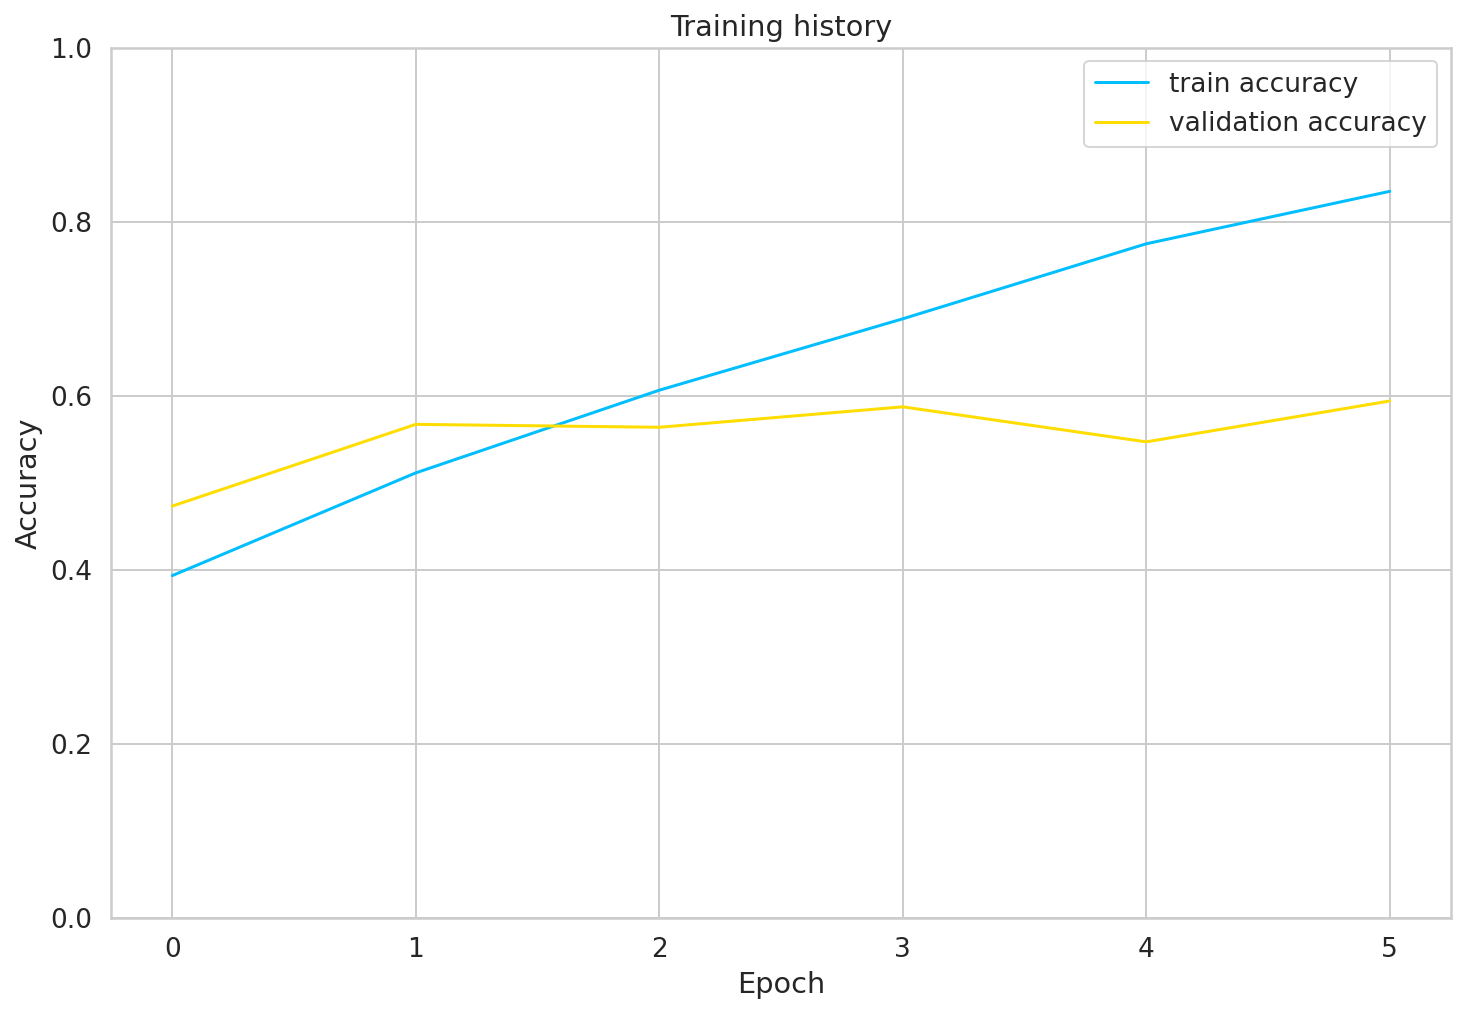

In [60]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [61]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()


0.5752508361204013

In [62]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [63]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [64]:
print(classification_report(y_test, y_pred, target_names=class_names))

                      precision    recall  f1-score   support

        Inconclusive       0.82      0.82      0.82        74
    Positive Extreme       0.56      0.58      0.57        52
    Negative Extreme       0.47      0.46      0.47        61
Positive Non-Extreme       0.44      0.50      0.47        50
Negative Non-Extreme       0.51      0.45      0.48        62

            accuracy                           0.58       299
           macro avg       0.56      0.56      0.56       299
        weighted avg       0.58      0.58      0.58       299



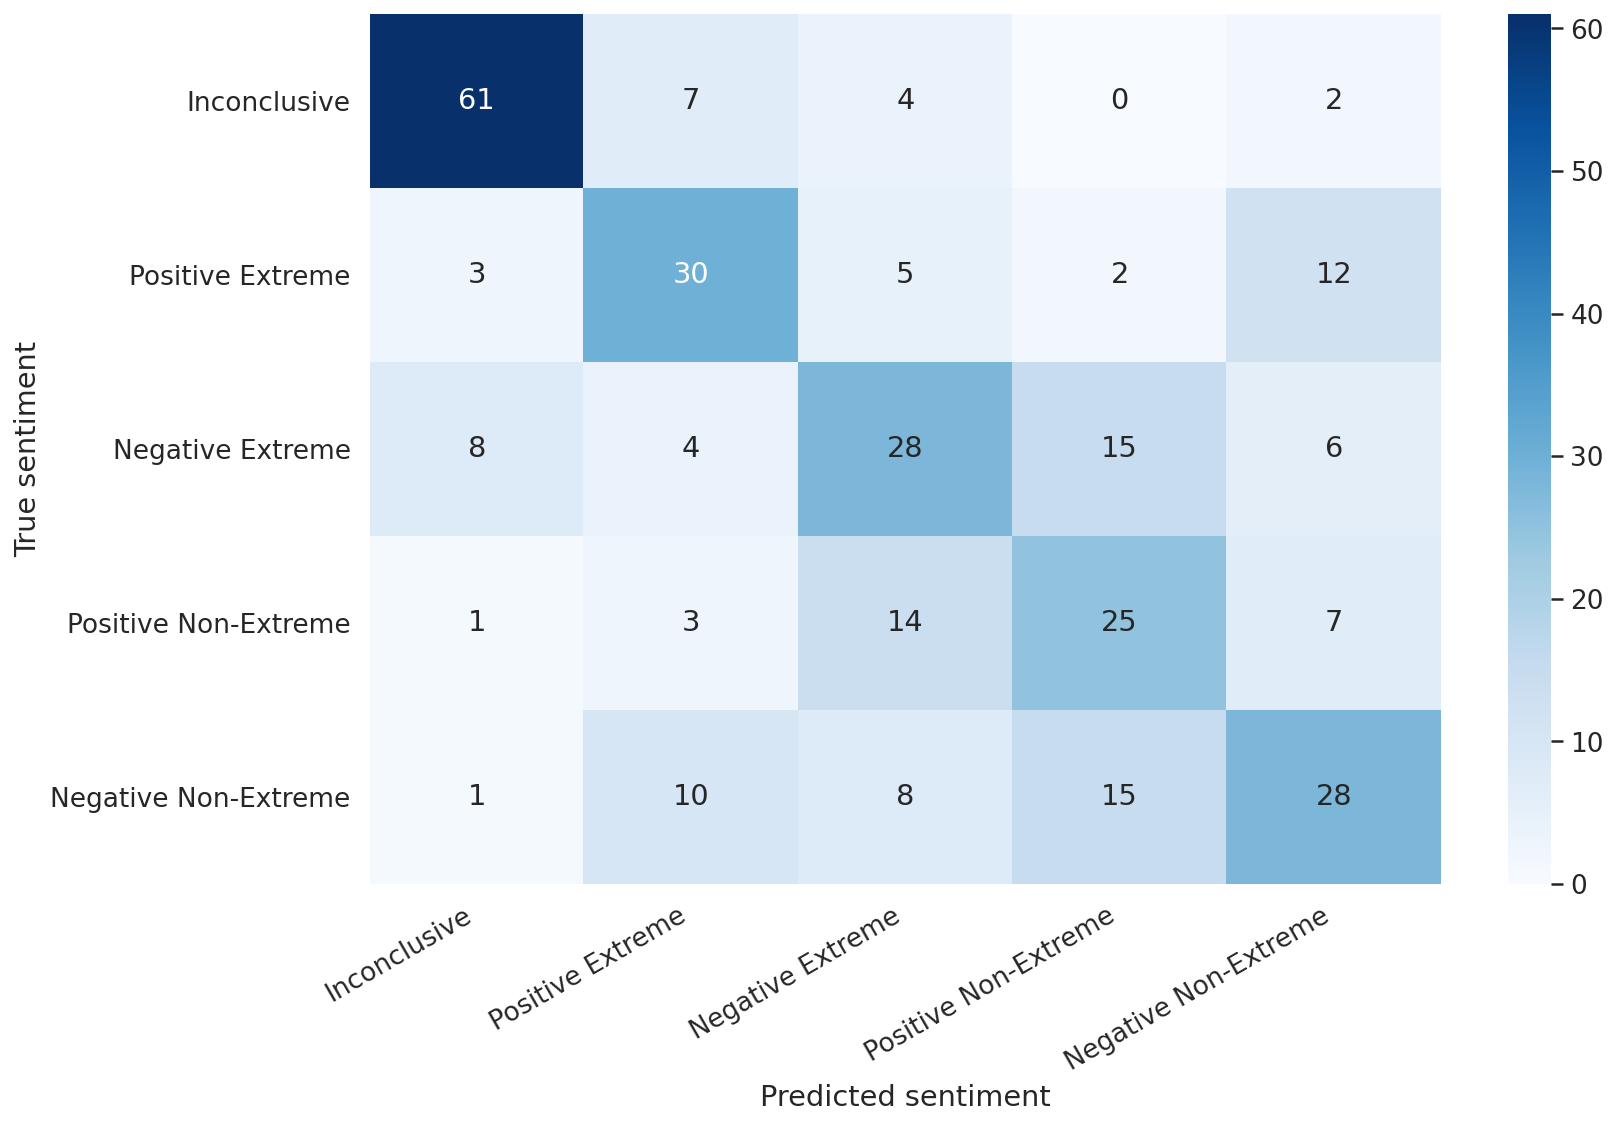

In [65]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)